Company XYZ is an e-commerce site that sells hand-made clothes.
You have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. This is a super common task for data scientists.
You only have information about the user first transaction on the site and based on that you have to make your classification ("fraud/no fraud").
These are the tasks you are asked to do:

- For each user, determine her country based on the numeric IP address.
- Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.
- Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?
- Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is,what kind of different user experiences would you build based on the model output?

In [1]:
ls

Fraud/
Fraud.zip
Fraud_analysis.ipynb
random_forest_classifier_and_analysis.py


In [2]:
import pandas as pd
import seaborn as sns
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
fraud = pd.read_csv('./Fraud/Fraud_Data.csv', iterator=True, chunksize=1000)

In [4]:
fraud.head()

AttributeError: 'TextFileReader' object has no attribute 'head'

In [7]:
fraud.dtypes

AttributeError: 'TextFileReader' object has no attribute 'dtypes'

In [8]:
ip_country = pd.read_csv('./Fraud/IpAddress_to_Country.csv')

In [9]:
ip_country.dtypes

lower_bound_ip_address    float64
upper_bound_ip_address      int64
country                    object
dtype: object

In [10]:
ip_country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [11]:
# ip_country['country'] = ip_country['country'].str

# For each user, determine her country based on the numeric IP address.


## The fraud csv is a little too big, I should do chunking to reduce the time it takes to perform analysis if I need it to run through a model.

In [12]:
def get_country_from_ip(ip_row):
    try:
        temp = ip_country[(ip_row > ip_country['lower_bound_ip_address']) & (ip_row < ip_country['upper_bound_ip_address'])]['country']
        return(temp.values[0])
    except:
        return('Nowhere')

In [13]:
# chunks = []
# for chunk in fraud:
#     chunks.append( chunk['ip_address'].apply(get_country_from_ip))
# full_ip_countries = pd.concat(chunks,ignore_index=True)

In [14]:
# f_chunk = pd.read_csv('Check1_900.csv', sep='\t', iterator=True, chunksize=1000)
# print tp
# #<pandas.io.parsers.TextFileReader object at 0x00000000150E0048>
# df = pd.concat(tp, ignore_index=True)

### Maybe lets just look at a smaller set of data and have a proof of concept-- The sorting of ip is too time complex, e.g. it takes forever to run.

In [15]:
fraud = pd.read_csv('./Fraud/Fraud_Data.csv')
fraud.shape

(151112, 11)

In [16]:
# so lets only get an eigth of the data to test on
fraud_eighth= fraud.iloc[0:fraud.shape[0]//8,:].copy()

In [48]:
fraud_eighth['signup_time']=pd.to_datetime(fraud_eighth['signup_time'])

In [49]:
fraud_eighth['purchase_time']=pd.to_datetime(fraud_eighth['purchase_time'])

In [50]:
fraud_eighth.describe()

,user_id,purchase_value,age,ip_address,class
count,18889.000000,18889.000000,18889.000000,1.888900e+04,18889.000000
mean,199576.752237,36.950394,33.103817,2.144131e+09,0.096564
std,115562.641944,18.406564,8.576195,1.249134e+09,0.295371
min,4.000000,9.000000,18.000000,9.344714e+04,0.000000
25%,99391.000000,22.000000,27.000000,1.071558e+09,0.000000
50%,199700.000000,34.000000,33.000000,2.134342e+09,0.000000
75%,298420.000000,49.000000,39.000000,3.233466e+09,0.000000
max,399995.000000,154.000000,72.000000,4.294546e+09,1.000000


In [51]:
fraud_eighth['ip_country'] = fraud_eighth['ip_address'].apply(lambda x: get_country_from_ip(x))

In [52]:
val= []
for ip_ad in fraud_eighth['ip_address'][0:10]:
    temp = get_country_from_ip(ip_ad)
    print(temp)

Japan
United States
United States
Nowhere
United States
Canada
Nowhere
United States
China
United States


In [20]:
fraud_eighth.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,ip_country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Nowhere
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [21]:
fraud_eighth['ip_country'].value_counts()

United States                      7303
Nowhere                            2712
China                              1556
Japan                               907
United Kingdom                      552
Korea Republic of                   519
Germany                             452
France                              387
Canada                              368
Brazil                              356
Australia                           239
Italy                               221
Netherlands                         202
Russian Federation                  188
Taiwan; Republic of China (ROC)     169
India                               160
Mexico                              141
Sweden                              121
Spain                               117
South Africa                         98
Indonesia                            88
Poland                               84
Switzerland                          84
Argentina                            84
Norway                               81


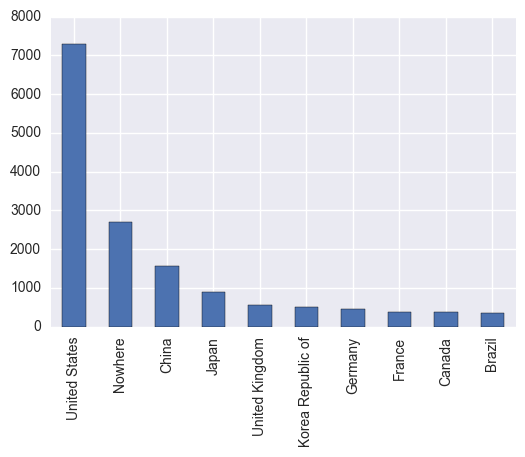

In [22]:
fraud_eighth['ip_country'].value_counts()[0:10].plot(kind ='bar')

In [23]:
## lets build a model on top of this...

In [24]:
fraud_eighth.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,ip_country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Nowhere
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


## Build a model to predict fraud or not

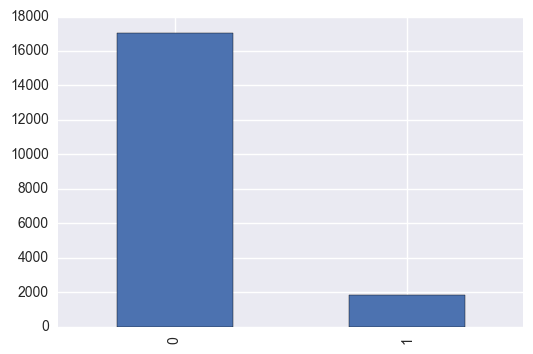

In [25]:
fraud_eighth['class'].value_counts().plot(kind='bar')

In [26]:
# Even in this subset of data the fraud class is scarce.
# It's hard to know if this representative of the whole dataset

In [32]:
from random_forest_classifier_and_analysis import *
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
features = fraud_eighth[['purchase_value','age']]
target = fraud_eighth['class']

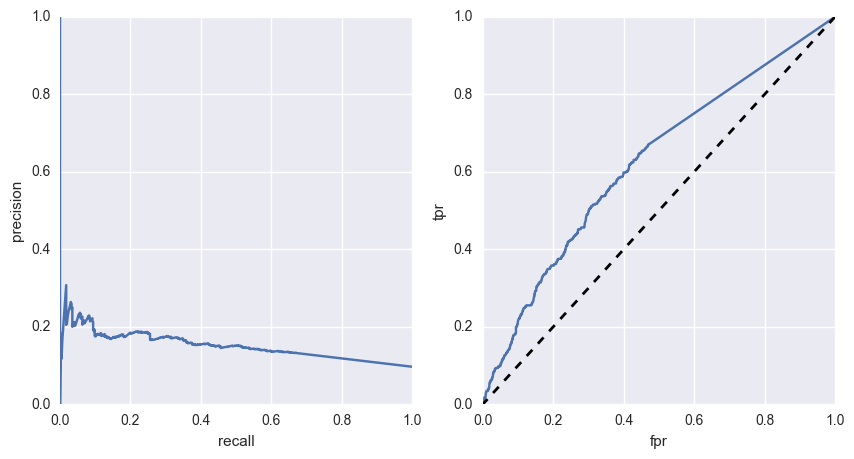

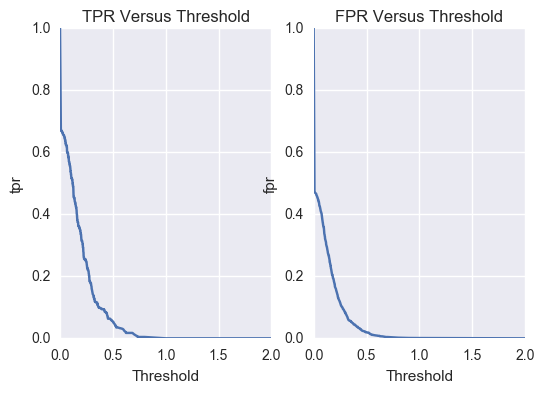

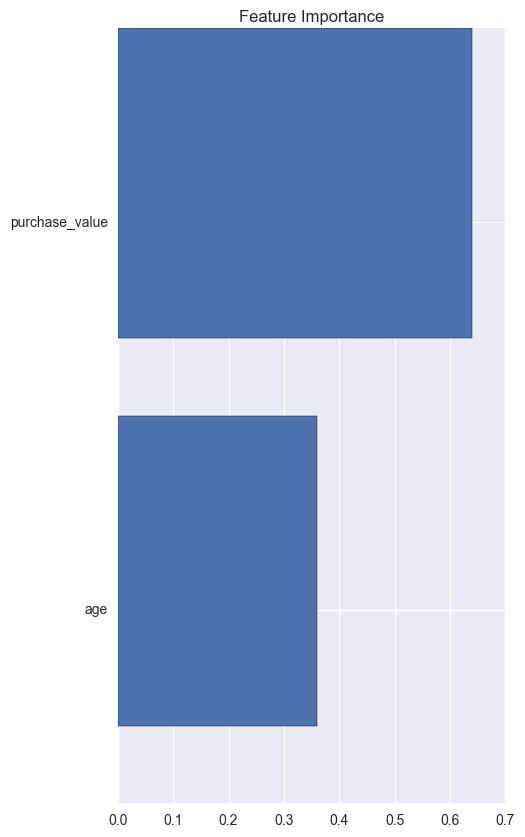

At threshold = 0.5
             precision    recall  f1-score   support

          0       0.91      0.98      0.94      4265
          1       0.23      0.05      0.09       458

avg / total       0.84      0.89      0.86      4723

accuracy:  0.891170865975


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [33]:
rfc_model_analysis(rfc,features,target)

## I'll add more feature fields to the features dataframe

In [36]:
dummies = pd.get_dummies(fraud_eighth[['source','browser','sex','ip_country']])

In [40]:
features_dummies = pd.concat([dummies,features],axis=1)

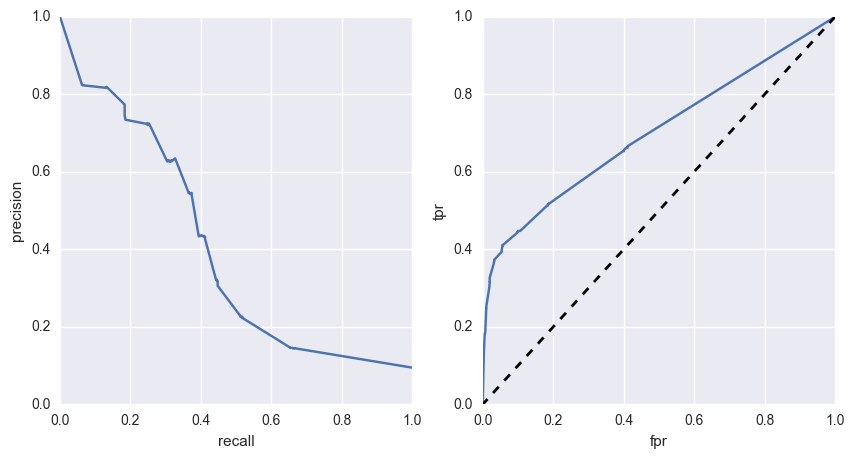

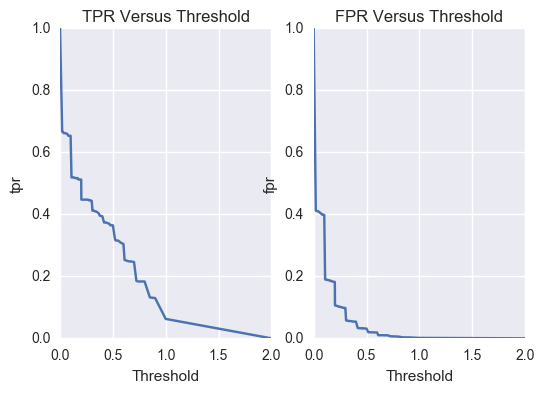

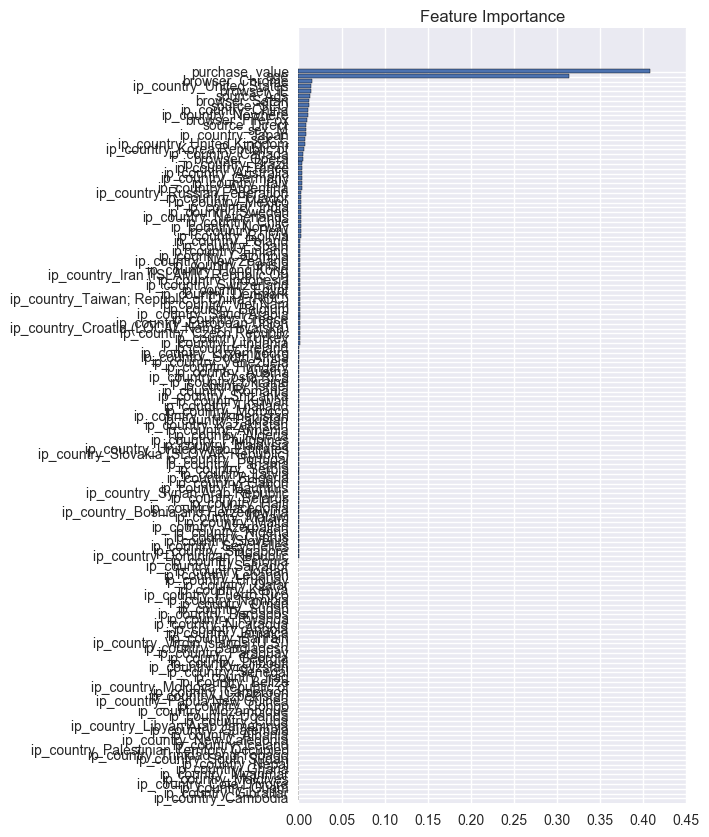

At threshold = 0.5
             precision    recall  f1-score   support

          0       0.93      0.98      0.96      4276
          1       0.63      0.33      0.43       447

avg / total       0.90      0.92      0.91      4723

accuracy:  0.918484014398


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [41]:
rfc_model_analysis(rfc,features_dummies,target)

In [64]:
# calculate the difference in time difference from sign to purchase
fraud_eighth['sign_to_purch']=(fraud_eighth['purchase_time']-fraud_eighth['signup_time'])

In [63]:
fraud_eighth['days_to_purch']=fraud_eighth['sign_to_purch'].apply(lambda x: x.days)

In [70]:
#check if all the devices are unique
fraud_eighth['device_id'].unique().shape[0]*1.0/fraud_eighth.shape[0] *100

96.83943035629203

In [71]:
# around 4% are using the same device...this could be a useful feature

In [90]:
fraud_eighth['device_counter'] =1
fraud_eighth['device_counter']=fraud_eighth.groupby(['device_id']).sum().reset_index()['device_counter']

In [92]:
fraud_eighth.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,ip_country,sign_to_purch,days_to_purch,device_counter
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,52 days 03:51:22,52,1.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,0 days 04:59:04,0,1.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,0 days 00:00:01,0,1.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Nowhere,5 days 16:41:25,5,1.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,50 days 11:31:01,50,1.0


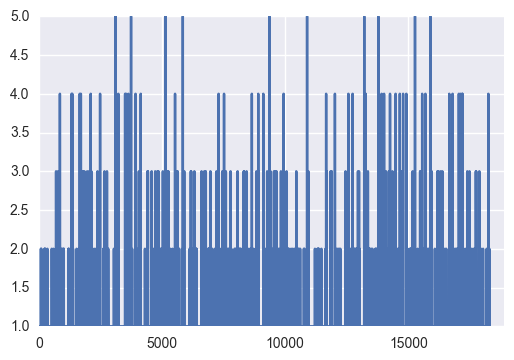

In [95]:
fraud_eighth['device_counter'].plot()

In [94]:
fraud_eighth['device_id'].value_counts().reset_index()

,index,device_id
0,HGVNRPOHIBZLJ,5
1,PPCQNVONMGSBH,5
2,IGKYVZDBEGALB,5
3,EIWWDKIBIWRWY,5
4,WPOJUXVISXBQS,5
5,VSZLPCXAISHQC,5
6,NKIHDDUCTWEVS,5
7,FFYVRWMTLSYPY,5
8,TPLAGOTQJCQGN,5
9,SUEKLSZWLASFR,5
